In [ ]:
import librosa
import numpy as np
import os
from pathlib import Path

def extract_features(audio_path):
    if Path(audio_path).exists():
        y, sr = librosa.load(audio_path)
        mfccs = librosa.feature.mfcc(y=y, sr=sr).mean(axis=1)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr).mean(axis=1)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr).mean()
        tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
        return np.hstack([mfccs, chroma, spec_cent, tempo])
    else:
        return np.nan


In [36]:
import pandas as pd
import re
import os
from pathlib import Path

sucess = pd.read_csv('../data/sucess_sample.csv')
fail = pd.read_csv('../data/fail_sample.csv')

In [23]:
#make dataset
def file_name(artist, track, _suffix = '.wav'):
    artistclean = re.sub(r"[^a-zA-Z0-9]", "_", artist)
    trackclean = re.sub(r"[^a-zA-Z0-9]", "_", track)
    return f"{trackclean}_{artistclean}{_suffix}"

aux = pd.DataFrame()
aux['filename'] = sucess.apply(lambda x: file_name(x['artist'], x['track']), axis=1)
aux['label'] = 1
aux_fail = pd.DataFrame()
aux_fail['filename'] = fail.apply(lambda x: file_name(x['artist'], x['track']), axis=1)
aux_fail['label'] = 0

dataframe = pd.concat([aux, aux_fail])
dataframe['label'].value_counts()


label
1    485
0    485
Name: count, dtype: int64

In [32]:
#removing downloads_failed files

all_musics = os.listdir('../data/musics/wav')
dataframe = dataframe[dataframe['filename'].isin(all_musics)]
dataframe['label'].value_counts()
dataframe.to_csv('../data/labels.csv')

In [ ]:
import pandas as pd
dataframe = pd.read_csv('../data/fataframe_15_anos.csv')


In [38]:
dataframe['features'] = dataframe['filename'].apply(lambda x: extract_features('../data/musics/wav/'+x))

In [57]:
dataframe['feat_len'] = dataframe['features'].apply(lambda x: len(x))
print(dataframe['feat_len'].value_counts())

feat_len
34    966
Name: count, dtype: int64


In [53]:
len(dataframe.loc[0, 'features'].values)

2

In [59]:
import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm


X = np.vstack(dataframe['features'].values)
y = np.array(dataframe['label'].values)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Treinar modelo
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Avaliação
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print("Acurácia:", accuracy_score(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.65      0.58      0.61       107
           1       0.55      0.62      0.58        87

    accuracy                           0.60       194
   macro avg       0.60      0.60      0.60       194
weighted avg       0.60      0.60      0.60       194

Acurácia: 0.5979381443298969


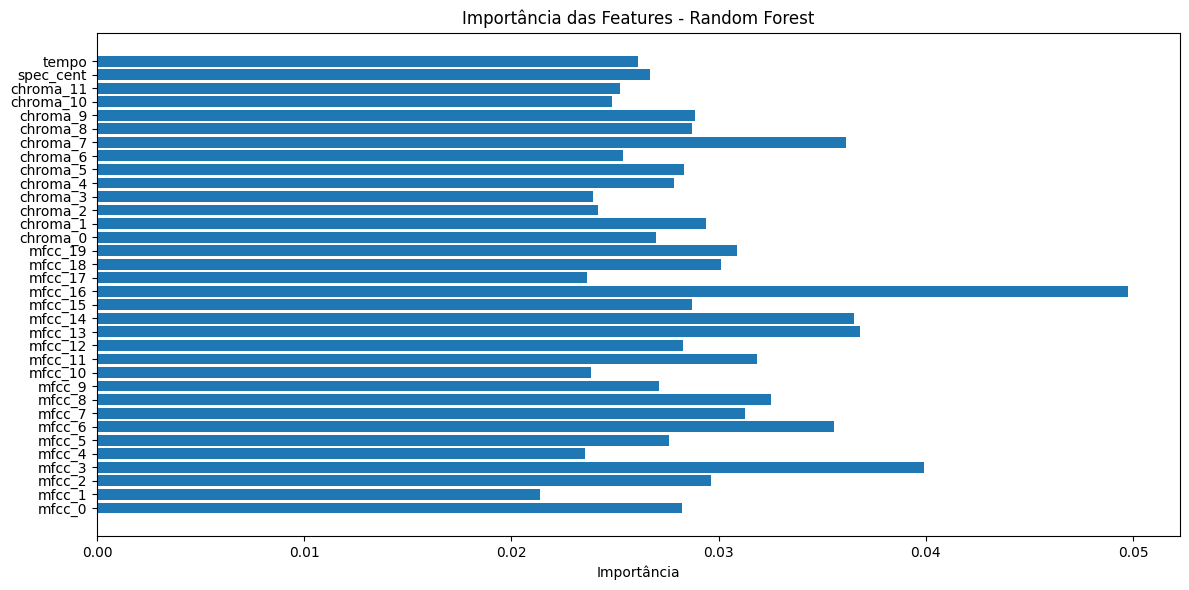

In [60]:
# verificando importancias
import matplotlib.pyplot as plt

importances = model.feature_importances_
feature_names = [f'mfcc_{i}' for i in range(20)] + \
                [f'chroma_{i}' for i in range(12)] + \
                ['spec_cent', 'tempo']

plt.figure(figsize=(12, 6))
plt.barh(feature_names, importances)
plt.xlabel("Importância")
plt.title("Importância das Features - Random Forest")
plt.tight_layout()
plt.show()

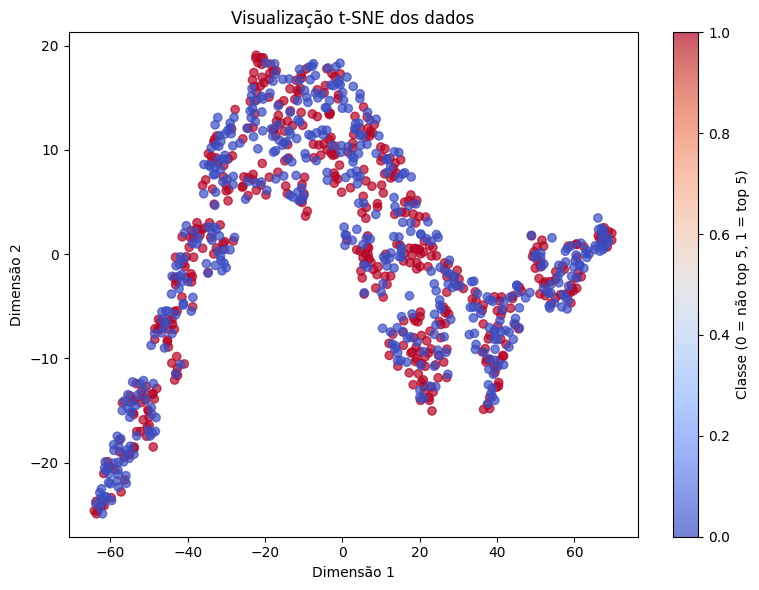

In [61]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_embedded = tsne.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, cmap='coolwarm', alpha=0.7)
plt.title("Visualização t-SNE dos dados")
plt.xlabel("Dimensão 1")
plt.ylabel("Dimensão 2")
plt.colorbar(label='Classe (0 = não top 5, 1 = top 5)')
plt.tight_layout()
plt.show()

In [62]:
#Xgboost
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

# Supondo que X e y já estejam prontos (com np.vstack e y convertido para int)
X = np.vstack(dataframe['features'].values)
y = dataframe['label'].values.astype(int)

# Dividir em treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Inicializar o classificador
model_xgb = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Treinar
model_xgb.fit(X_train, y_train)

# Prever
y_pred = model_xgb.predict(X_test)

# Avaliar
print(classification_report(y_test, y_pred))
print("Acurácia:", accuracy_score(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.63      0.64      0.63       107
           1       0.55      0.54      0.54        87

    accuracy                           0.59       194
   macro avg       0.59      0.59      0.59       194
weighted avg       0.59      0.59      0.59       194

Acurácia: 0.5927835051546392


c:\Users\Xonas\anaconda3\envs\ia_music\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:29:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


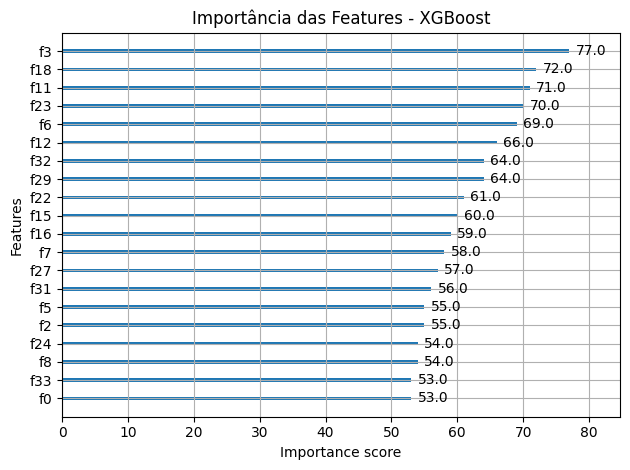

In [63]:
import matplotlib.pyplot as plt
xgb.plot_importance(model_xgb, max_num_features=20)
plt.title("Importância das Features - XGBoost")
plt.tight_layout()
plt.show()


In [78]:
#testando o treinamento com mais dados

concated = pd.concat([sucess, fail])
concated['filename'] = concated.apply(lambda x: file_name(x["artist"], x['track']), axis= 1)

new_dataframe = dataframe.merge(concated, how='inner', on='filename')
new_dataframe.to_csv('../data/big_dataframe.csv')